<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_1_uncertainty.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Types of Uncertainty

In this assignment, you will explore **epistemic** and **aleatoric** uncertainty in machine learning.
You will use a small dataset to visualize predictions, compute uncertainty, and reflect on the differences between these two key concepts.

---
## Learning Goals
- Understand the difference between **epistemic** (knowledge/model) and **aleatoric** (data/noise) uncertainty
- Learn how to model uncertainty using probability distributions
- Implement uncertainty estimation with a softmax-based classifier
- Visualize how uncertainty appears in decision boundaries
- Practice interpreting results and reflecting on uncertainty in real-world ML tasks

## Part 1 — dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a toy dataset
X, y = make_classification(
    n_samples=400, n_features=2, n_redundant=0, n_clusters_per_class=1,
    class_sep=1.0, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Part 2 — Softmax Probabilities (Aleatoric Uncertainty)

Here you’ll train a logistic regression classifier and use its predicted probabilities to measure **aleatoric uncertainty**.
Aleatoric uncertainty shows up when points are near the decision boundary (probabilities close to 0.5).


In [2]:
clf = LogisticRegression().fit(X_train, y_train)

probs = clf.predict_proba(X_test)
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

Accuracy: 0.875


### TODO:

Find the points that have the most uncertain predictions.  Think about this a little bit - can you come up with a way to quantify a "certain prediction" vs. an "uncertain prediction"?

In [3]:
# XXX your code here
predicted_class_prob = np.max(probs, axis=1)
uncertainty = -np.abs(predicted_class_prob - 0.5)
# Show most uncertain predictions
most_uncertain_idx = np.argsort(-uncertainty)[:5]
print("Most uncertain samples (indices):", most_uncertain_idx)
print("Probabilities for those samples:\n", probs[most_uncertain_idx])


Most uncertain samples (indices): [ 19 114  69  91  56]
Probabilities for those samples:
 [[0.53149291 0.46850709]
 [0.5440848  0.4559152 ]
 [0.54408824 0.45591176]
 [0.45486977 0.54513023]
 [0.4240464  0.5759536 ]]


## Part 3 — Visualizing Uncertainty

---

### What is a decision boundary?  
A **decision boundary** is a line that a classifier learns to **separate different classes** of data.  
- Points on one side of the boundary are predicted as one class.  
- Points on the other side are predicted as another.  

In two dimensions, we can plot this boundary directly. The shaded regions in the visualization show the classifier’s predicted classes, while the dots are the actual data points.  

Where the dots overlap or cluster near the boundary, the classifier has more difficulty deciding — this is where we see **uncertainty**.  

- **Aleatoric uncertainty**: appears near the decision boundary, caused by noisy or overlapping data.  
- **Epistemic uncertainty**: occurs in regions far away from any training data (where the model is unsure because it has not “seen” those inputs before).  

---

When you look at the plot:  
- The **shaded regions** represent the classifier’s predictions.  
- The **solid boundary line** shows where the model is exactly 50/50 between classes.  
- The **data points** show the ground-truth labels.  

</details>


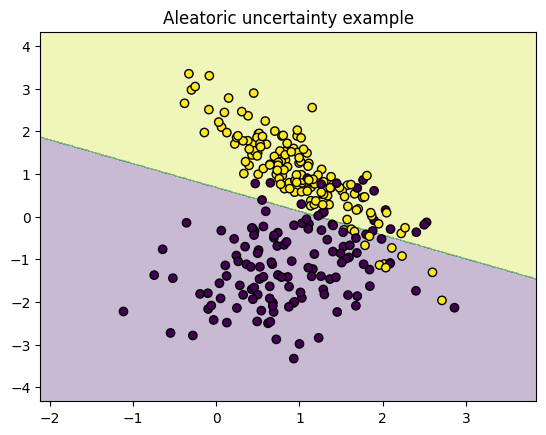

In [4]:
def plot_decision_boundary(clf, X, y, title="Decision boundary"):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    plt.title(title)
    plt.show()

plot_decision_boundary(clf, X_train, y_train, "Aleatoric uncertainty example")

## Part 4 — Epistemic Uncertainty (via Model Variation)

Epistemic uncertainty can be explored by varying the model or subsampling the training data.
We’ll train multiple logistic regression models on bootstrapped samples and measure the variation in predictions.


In [5]:
from sklearn.utils import resample

n_models = 20
all_probs = []

for i in range(n_models):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    clf_boot = LogisticRegression().fit(X_boot, y_boot)
    all_probs.append(clf_boot.predict_proba(X_test))

all_probs = np.array(all_probs)  # shape (n_models, n_samples, n_classes)

# Epistemic uncertainty = variance across models
epistemic_uncertainty = all_probs.var(axis=0).mean(axis=1)

print("Sample epistemic uncertainties:", epistemic_uncertainty[:10])


Sample epistemic uncertainties: [1.18561488e-04 4.90491887e-05 1.16268281e-03 4.66090737e-05
 8.28161886e-04 1.47239788e-04 1.09531739e-03 4.51186822e-04
 1.24974306e-04 1.39166442e-04]


### TODO

Now, using the plot_decision_boundary function from Part 3 and the code in Part 4, can you come up with a way to visualize the uncertainty in the decision boundary?

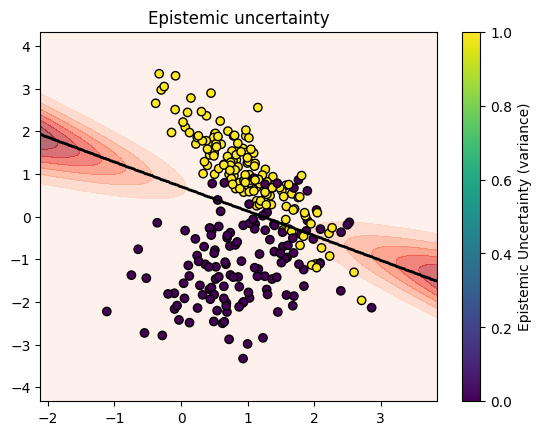

In [9]:
def plot_uncertainty_boundary(all_clfs, X, y, title="Epistemic uncertainty"):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Stack predictions from all models at each grid point
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    all_grid_probs = []
    for clf in all_clfs:
        probs = clf.predict_proba(grid_points)[:, 1]  # Probability for class 1
        all_grid_probs.append(probs)
    all_grid_probs = np.array(all_grid_probs)  # (n_models, n_points)

    # Calculate variance (uncertainty) at each grid point
    uncertainty = all_grid_probs.var(axis=0)
    uncertainty = uncertainty.reshape(xx.shape)

    # Plot uncertainty as background
    plt.contourf(xx, yy, uncertainty, cmap="Reds", alpha=0.6)

    # Plot decision boundary from majority vote
    majority_preds = (all_grid_probs.mean(axis=0) > 0.5).astype(int)
    Z = majority_preds.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    plt.title(title)
    plt.colorbar(label="Epistemic Uncertainty (variance)")
    plt.show()

all_clfs = []
for i in range(n_models):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    clf_boot = LogisticRegression().fit(X_boot, y_boot)
    all_clfs.append(clf_boot)

plot_uncertainty_boundary(all_clfs, X_train, y_train)

## Part 5 — Reflection

Answer the following in 2–3 sentences each:

1. Which type of uncertainty did you observe near the decision boundary? Why?  
2. How did epistemic uncertainty change across different bootstrap models?  
3. Give a real-world example where epistemic uncertainty dominates, and one where aleatoric uncertainty dominates.  


1. The type of uncertainty we can observe near the decision boundary is  aleatoric uncertainty because the result of the predicted probabilities is closer to 0.5, which leads to points nearer to the boundary that are very ambiguous.
2. the predictions disagreed more in the model's lack of knoweldge and epistemic uncertainty increased because it depends on the amount and diversity of the training data.
3. Epistemic uncertainty dominates in situations like medical diagnosis for a rare disease and Aleatoric uncertainty dominates in tasks like predicting a coin flip